In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

from sklearn.metrics import log_loss, classification_report
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [9]:
test_df = pd.read_csv('../input/test/test.csv', 
                      names=['n'+str(i) for i in range(1, 65)])

In [56]:
train_df = pd.concat([pd.read_csv('../input/train/0.csv'), pd.read_csv('../input/train/1.csv'),
                       pd.read_csv('../input/train/2.csv'), pd.read_csv('../input/train/3.csv'),]
                      ,axis=0)
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.columns = ['n'+str(i) for i in range(1, 65)] + ['label']
train_df.reset_index(drop=True, inplace=True)

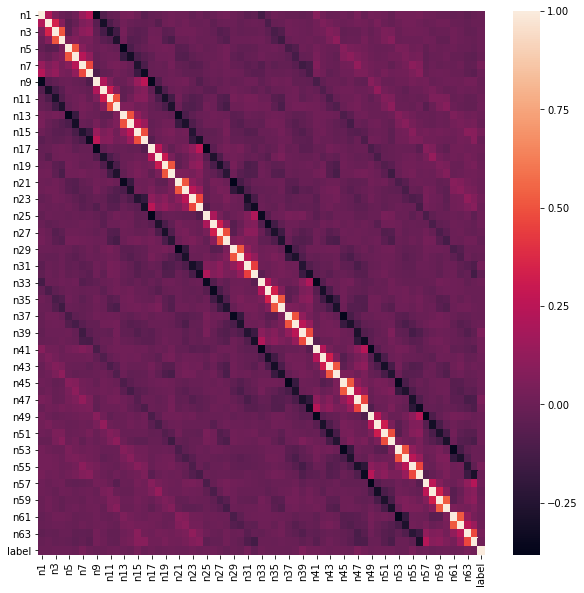

In [102]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_df.corr())

In [123]:
def stdd(arr):
    return arr.max(1).values, arr.min(1).values, arr.std(1).values

train_feat = [stdd(train_df.iloc[:, :8]), stdd(train_df.iloc[:, 8:16]),
             stdd(train_df.iloc[:, 16:24]), stdd(train_df.iloc[:, 24:32]),
             stdd(train_df.iloc[:, 32:40]), stdd(train_df.iloc[:, 40:48]),
             stdd(train_df.iloc[:, 48:56]), stdd(train_df.iloc[:, 56:64])]

test_feat = [stdd(test_df.iloc[:, :8]), stdd(test_df.iloc[:, 8:16]),
             stdd(test_df.iloc[:, 16:24]), stdd(test_df.iloc[:, 24:32]),
             stdd(test_df.iloc[:, 32:40]), stdd(test_df.iloc[:, 40:48]),
             stdd(test_df.iloc[:, 48:56]), stdd(test_df.iloc[:, 56:64])]

In [124]:
train_feat = np.concatenate(train_feat).T
test_feat = np.concatenate(test_feat).T

In [134]:
params = {
    'learning_rate': 0.01,
    'min_child_samples': 5,
    'max_depth': 6,
    'lambda_l1': 2,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'n_estimators': 5000,
    'metric': 'multi_error',
    'num_class': 4,
    'feature_fraction': .75,
    'bagging_fraction': .75,
    'seed': 99,
    'num_threads': 40,
    'verbose': -1
}

cv_results1 = lgb.cv(
        params,
        lgb.Dataset(np.concatenate([train_df.drop(['label'], axis=1).values, train_feat], axis=1), 
                                    label=train_df['label'].values),
        num_boost_round=200,
        nfold=7, verbose_eval=False,
        early_stopping_rounds=200,
)
# print('CV AUC: ', len(cv_results1['auc-mean']), cv_results1['auc-mean'][-1])

/usr/local/lib/python3.5/site-packages/lightgbm/engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [135]:
pd.DataFrame(cv_results1)

,multi_error-mean,multi_error-stdv
0,0.356946,0.015378
1,0.233881,0.016312
2,0.195106,0.013979
3,0.180306,0.013004
4,0.171991,0.009962
5,0.165878,0.011189
6,0.157193,0.012209
7,0.152910,0.009738
8,0.150464,0.010811
9,0.146427,0.011154


In [140]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

n_fold = 10
skf = StratifiedKFold(n_splits = n_fold, shuffle = True)
eval_fun = roc_auc_score

def run_oof(clf, X_train, y_train, X_test, kf):
    print(clf)
    preds_train = np.zeros((len(X_train), 4), dtype = np.float)
    preds_test = np.zeros((len(X_test), 4), dtype = np.float)
    train_loss = []; test_loss = []

    i = 1
    for train_index, test_index in kf.split(X_train, y_train):
        x_tr = X_train[train_index]; x_te = X_train[test_index]
        y_tr = y_train[train_index]; y_te = y_train[test_index]
        clf.fit(x_tr, y_tr, eval_set = [(x_te, y_te)], early_stopping_rounds = 500, verbose = False)
        
        # train_loss.append(eval_fun(y_tr, clf.predict_proba(x_tr)[:]))
        # test_loss.append(eval_fun(y_te, clf.predict_proba(x_te)[:]))

        preds_train[test_index] = clf.predict_proba(x_te)[:]
        preds_test += clf.predict_proba(X_test)[:]

        # print('{0}: Train {1:0.7f} Val {2:0.7f}/{3:0.7f}'.format(i, train_loss[-1], test_loss[-1], np.mean(test_loss)))
        print('-' * 50)
        i += 1
    print('Train: ', train_loss)
    print('Val: ', test_loss)
    print('-' * 50)
    # print('Train{0:0.5f}_Test{1:0.5f}\n\n'.format(np.mean(train_loss), np.mean(test_loss)))
    preds_test /= n_fold
    return preds_train, preds_test

params = {
    'learning_rate': 0.01,
    'min_child_samples': 5,
    'max_depth': 5,
    'lambda_l1': 2,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'n_estimators': 2000,
    'metric': 'multi_error',
    'num_class': 4,
    'feature_fraction': .75,
    'bagging_fraction': .85,
    'seed': 99,
    'num_threads': 20,
    'verbose': -1
}

train_pred, test_pred = run_oof(lgb.LGBMClassifier(**params), 
                                np.concatenate([train_df.drop(['label'], axis=1).values, train_feat], axis=1), 
                                train_df['label'].values, 
                                np.concatenate([test_df.values, test_feat], axis=1), 
                                skf)


LGBMClassifier(bagging_fraction=0.85, boosting='gbdt', boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.75,
        importance_type='split', lambda_l1=2, learning_rate=0.01,
        max_depth=5, metric='multi_error', min_child_samples=5,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
        n_jobs=-1, num_class=4, num_leaves=31, num_threads=20,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, seed=99, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1)
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
---------------------------------------

In [141]:
np.mean(np.argmax(train_pred, 1) == train_df['label'].values)

0.9558409785932722

In [142]:
submit_df = pd.DataFrame()

In [143]:
submit_df['id'] = range(1, len(test_pred)+1)
submit_df['label'] = np.argmax(test_pred, 1)

In [144]:
submit_df.to_csv('lgb.csv', index=None, header=None)